<a href="https://colab.research.google.com/https://github.com/gned0/pancreatic_cancer_prediction/blob/main/pancreatic_cancer_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Progetto d'esame: Predizione di cancro al pancreas tramite biomarker nelle urine

**Progetto per l'esame di Programmazione di Applicazioni Data Intensive, A.A. 2020/2021**

**Studente**: Gian Luca Nediani

**E-mail**: `gianluca.nediani@studio.unibo.it` 

**Matricola**: 0000873600

## Analisi del problema

**Adenocarcinoma pancreatico**

L'adenocarcinoma pancreatico è la tipologia più comune di tumore al pancreas, nonchè una delle neoplasie con la maggiore mortalità, con soltanto il 9% dei malati che sopravvive oltre 5 anni dalla diagnosi. 

Un [paper](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1003489) open-source del 2020 evidenzia la correlazione tra la comparsa di questo tumore, e più in generale di malattie al pancreas, con una serie di biomarker facilmente rintracciabili in un esame delle urine. Asssieme al paper appena citato, è messo a disposizione il dataset su cui sono stati condotti gli studi.

**Biomarker**

Un biomarker, o biomarcatore, è un indicatore di uno stato biologico in un paziente; viene individuato con analisi di laboratorio. Un esempio di biomarker è il livello di colesterolo, o la quantità di globuli rossi nel sangue. Nell'analisi delle urine vengono generalmente individuati biomarker di natura proteica.

**Obiettivo del progetto**

L'obiettivo di questo progetto è, a partire dal dataset fornito assieme al paper sopracitato, di costruire un modello efficace in grado di predire l'insorgere di malattie al pancreas, e nello specifico di adenocarcinoma pancreatico, a partire da quattro biomarker urinari dei pazienti e di due loro dati anagrafici (sesso ed età).

In altri termini, l'obiettivo è di predirre una variabile discreta fra 3 possibilità: 1 (nessuna malattia), 2 (malattia benigna al pancreas), 3 (tumore al pancreas). Si tratta quindi di un problema di classificazione multiclasse.

L'obiettivo minimo è di costruire un modello migliore di un modello casuale.

### Setup

Import delle librerie necessarie

In [70]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd

Acquisizione del dataset

In [71]:
import os.path
from urllib.request import urlretrieve

if not os.path.exists("patients_data.csv"):
    urlretrieve("https://raw.githubusercontent.com/gned0/pancreatic_cancer_prediction/main/Debernardi%20et%20al%202020%20data.csv", "patients_data.csv")

data = pd.read_csv('patients_data.csv', delimiter=',')

### Analisi delle variabili



In [72]:
data.head()

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


**Variabile da predire**
* `diagnosis`: diagnosi sullo stato del pancreas, valori da 1 a 3. 1 = nessuna malattia al pancreas, 2 = malattia benigna al pancreas, 3 = adenocarcinoma del pancreas

**Variabili indipendenti**
* `patient_cohort`: coorte dei dati (1 o 2)
* `sample_origin`: fonte della entry (es. ESP = Spanish National Cancer Research Centre, Madrid, Spain) 
* `age`: età del paziente in anni
* `sex`: sesso del paziente, M = male, F = female
* `stage`: per i pazienti con diagnosi di tipo 3, stadio del cancro
* `benign_sample_diagnosis`: per pazienti con malattia benigna, la tipologia di malattia
* `plasma_CA19_9`: biomarker, livello dell'anticorpo monoclonale CA19-9, spesso associato a carcinoma pancreatico
* `creatinine`: Biomarker del corretto funzionamento dei reni
* `LYVE1`: biomarker, livello nelle urine del recettore ialuronico endoteliale dei vasi linfatici 1, proteina con un potenziale ruolo nella metastasi tumorale
* `REG1B`: biomarker, livello nelle urine della litostatina-1-beta, proteina associata all'abilità di rigenerazione del pancreas 
* `TFF1`: biomarker, livello nelle urine del fattore di trifoglio 1, proteina associata all'abilità di rigenerazione del tratto urinario 
* `REG1A`: biomarker, livello nelle urine della litostatina-1-alfa, proteina associata all'abilità di rigenerazione del pancreas 



### Analisi generale del dataset

#### Fonte dei dati
Come visto nell'analisi delle variabili, i dati provengono da fonti diverse

In [73]:
data["sample_origin"].unique()

array(['BPTB', 'LIV', 'ESP', 'UCL'], dtype=object)

Di seguito viene mostrata in percentuale la distribuzione delle diagnosi rispetto alle quattro diverse fonti dei dati

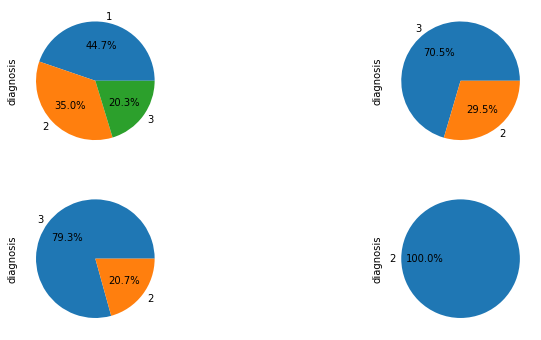

In [74]:
plt.figure(figsize=(12, 6))
for n, origin in enumerate(data["sample_origin"].unique(), start=1):
  frame = data.loc[data['sample_origin'] == origin]
  frame["diagnosis"].value_counts(normalize=True).plot.pie(autopct='%1.1f%%', ax=plt.subplot(2, 2, n))

Come si nota, le distribuzioni non sono simili. Ad esempio, la quarta fonte di dati riporta solo diagnosi di tipo 2. Questo non rappresenta però un problema, in quanto i dati sono comunque raccolti secondo gli stessi criteri.

Sarebbe tuttavia ideale avere in totale una distribuzione uniforme delle tre diverse diagnosi, in modo che il modello possa essere addestrato su un numero adeguato di ciascuna di esse. In caso di classi sbilanciate si avranno dei problemi a costruire un modello preciso e sarà necessario ricorrere a tecniche come pesi per le classi o undersampling.

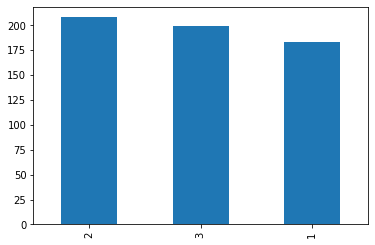

In [75]:
data["diagnosis"].value_counts().plot.bar()

A differenza di quanto visto per le singole fonti, in senso assoluto i dati sono distribuiti in maniera uniforme.

#### Esplorazione dei biomarker

In [76]:
biomarkers = data[["plasma_CA19_9", "creatinine", "LYVE1", "REG1B", "TFF1", "REG1A"]]
biomarkers.describe()

,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
count,350.000000,590.000000,590.000000,590.000000,590.000000,306.000000
mean,654.002944,0.855383,3.063530,111.774090,597.868722,735.281222
std,2430.317642,0.639028,3.438796,196.267110,1010.477245,1477.247724
min,0.000000,0.056550,0.000129,0.001104,0.005293,0.000000
25%,8.000000,0.373230,0.167179,10.757216,43.961000,80.692000
50%,26.500000,0.723840,1.649862,34.303353,259.873974,208.538500
75%,294.000000,1.139482,5.205037,122.741013,742.736000,649.000000
max,31000.000000,4.116840,23.890323,1403.897600,13344.300000,13200.000000


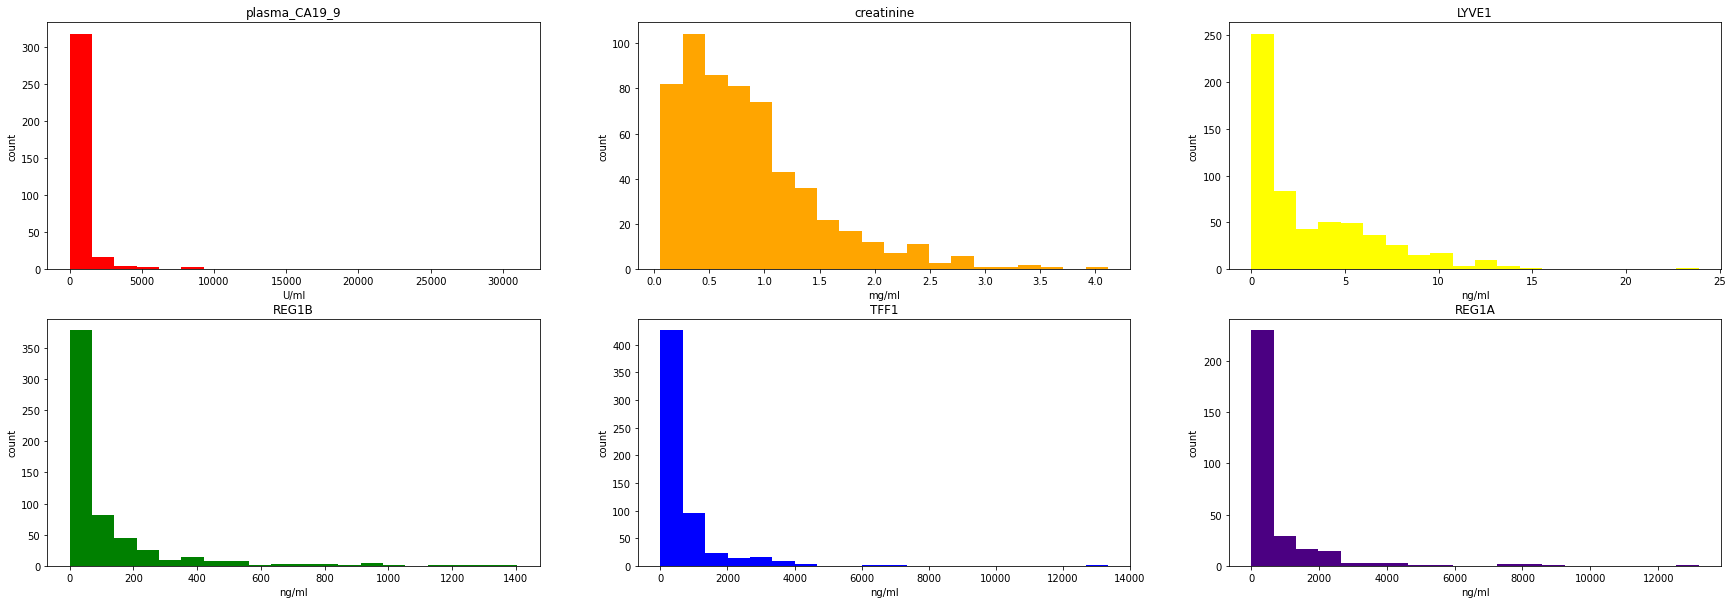

In [77]:
plt.figure(figsize=(30, 10))

plt.subplot(2, 3, 1)
plt.title('plasma_CA19_9')
plt.hist(data['plasma_CA19_9'], color='red', bins=20)
plt.ylabel('count')
plt.xlabel('U/ml')

plt.subplot(2, 3, 2)
plt.title('creatinine')
plt.hist(data['creatinine'], color='orange', bins=20)
plt.ylabel('count')
plt.xlabel('mg/ml')

plt.subplot(2, 3, 3)
plt.title('LYVE1')
plt.hist(data['LYVE1'], color='yellow', bins=20)
plt.ylabel('count')
plt.xlabel('ng/ml')

plt.subplot(2, 3, 4)
plt.title('REG1B')
plt.hist(data['REG1B'], color='green', bins=20)
plt.ylabel('count')
plt.xlabel('ng/ml')

plt.subplot(2, 3, 5)
plt.title('TFF1')
plt.hist(data['TFF1'], color='blue', bins=20)
plt.ylabel('count')
plt.xlabel('ng/ml')

plt.subplot(2, 3, 6)
plt.title('REG1A')
plt.hist(data['REG1A'], color='indigo', bins=20)
plt.ylabel('count')
plt.xlabel('ng/ml')

plt.show()

#### Correlazione tra variabili

Nella seguente cella viene generata una tabella che mostra la correlazione tra variabili secondo l'indice di Pearson, ovvero $\sigma xy/\sigma x \sigma y$. Ciò che interessa maggiormente è la correlazione fra la variabile da predire `diagnosis` e le altre variabili.

In [78]:
data.corr(method='pearson')

,age,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
age,1.000000,0.308251,0.143203,-0.069393,0.329805,0.204317,0.207868,0.060082
diagnosis,0.308251,1.000000,0.263950,0.074888,0.540384,0.383516,0.392613,0.260110
plasma_CA19_9,0.143203,0.263950,1.000000,-0.029418,0.257115,0.175814,0.150694,0.123293
creatinine,-0.069393,0.074888,-0.029418,1.000000,0.338533,0.261906,0.397795,0.060248
LYVE1,0.329805,0.540384,0.257115,0.338533,1.000000,0.543075,0.577363,0.277696
REG1B,0.204317,0.383516,0.175814,0.261906,0.543075,1.000000,0.690228,0.555385
TFF1,0.207868,0.392613,0.150694,0.397795,0.577363,0.690228,1.000000,0.418015
REG1A,0.060082,0.260110,0.123293,0.060248,0.277696,0.555385,0.418015,1.000000


Le variabili più correlate a `diagnosis` sono `LYVE1` `REG1B` e `TFF1`. 

<Figure size 864x216 with 0 Axes>

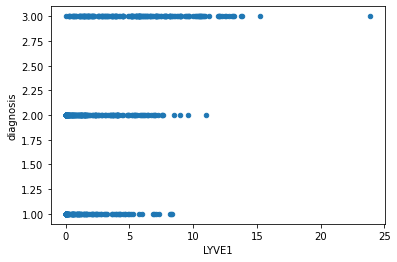

In [79]:
plt.figure(figsize=(12, 3))
data.plot.scatter("LYVE1", "diagnosis");

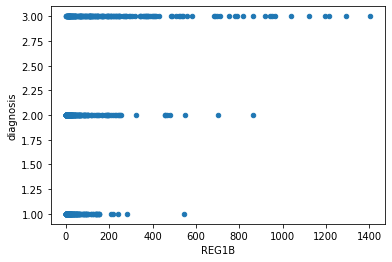

In [80]:
data.plot.scatter("REG1B", "diagnosis");

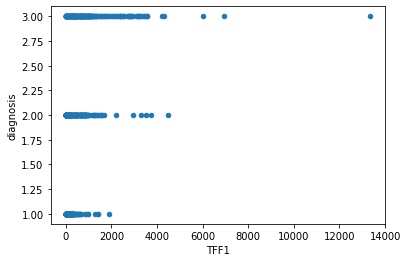

In [81]:
data.plot.scatter("TFF1", "diagnosis");

Possiamo intuire che al crescere del valore di questi 3 biomarker altamente correlati con la diagnosi, crescono anche i casi di malattie benigne e maligne al pancreas.

#### Età dei pazienti

È ampiamente [dimostrato](https://www.cancer.gov/about-cancer/causes-prevention/risk/age) che con l'avanzare dell'età, aumenti il rischio di sviluppare neoplasie. In molti studi, l'età è considerato il maggior fattore di rischio nella diagnosi di tumori. Sarà quindi rilevante analizzare l'età nei pazienti presenti nel dataset. Anche il sesso dei pazienti ha una incidenza sullo svilupparsi di malattie al pancreas e verrà quindi preso in considerazione dal modello.

Nel seguente istogramma viene mostrata la distribuzione del sesso e dell'età nel dataset

sex
F    AxesSubplot(0.125,0.125;0.775x0.755)
M    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

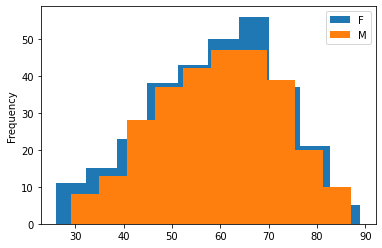

In [82]:
data.groupby("sex").age.plot.hist(legend=True)

Viene ora visualizzato con una stima kernel density il variare della diagnosi al crescere dell'età

diagnosis
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

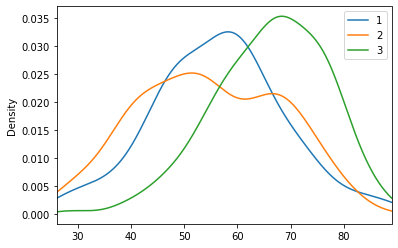

In [83]:
data.groupby("diagnosis").age.plot.kde(legend=True, xlim=(data["age"].min(), data["age"].max()))

In questo caso, è difficile riconoscere dei pattern in maniera intuitiva. Si può comunque vedere che la diagnosi 3, ovvero malattie maligne, è concentrata sui pazienti in età avanzata.

## Pre-processing del dataset

### Rimozione di variabili non rilevanti per la classificazione

Per prima cosa, impostiamo la colonna `sample_id`, contenente un identificatore univoco per ogni entry, come indice del dataset, in quanto non ci servirà per la predizione.



In [84]:
data = data.set_index("sample_id")
data

,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
sample_id,,,,,,,,,,,,,
S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.948840,654.282174,1262.000
S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.467030,209.488250,228.407
S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.366000,461.141000,NaN
S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.579000,142.950000,NaN
S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.540000,41.088000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
S549,Cohort2,BPTB,68,M,3,IV,NaN,NaN,0.52026,7.058209,156.241000,525.178000,NaN
S558,Cohort2,BPTB,71,F,3,IV,NaN,NaN,0.85956,8.341207,16.915000,245.947000,NaN
S560,Cohort2,BPTB,63,M,3,IV,NaN,NaN,1.36851,7.674707,289.701000,537.286000,NaN


A questo punto, occorre rimuovere le colonne `patient_cohort` e `sample_origin`. Come già visto, queste due informazioni riguardano solo l'origine dei dati, ma non influenzano la diagnosi, in quanto nonostante l'origine, tutti i dati sono stati raccolti con gli stessi criteri.

In [85]:
data = data.drop(columns=["patient_cohort", "sample_origin"])
data

,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
sample_id,,,,,,,,,,,
S1,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.948840,654.282174,1262.000
S10,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.467030,209.488250,228.407
S100,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.366000,461.141000,NaN
S101,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.579000,142.950000,NaN
S102,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.540000,41.088000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
S549,68,M,3,IV,NaN,NaN,0.52026,7.058209,156.241000,525.178000,NaN
S558,71,F,3,IV,NaN,NaN,0.85956,8.341207,16.915000,245.947000,NaN
S560,63,M,3,IV,NaN,NaN,1.36851,7.674707,289.701000,537.286000,NaN


### Rimozione di variabili non conosciute a priori

Nel dataset sono presenti informazioni che non possono essere usate per la predizione, in quanto non conosciute a priori.

Si tratta ovviamente di `stage` (non è possibile sapere lo stadio del tumore se non si sa nemmeno se il paziente è malato) e di `benign_sample_diagnosis` (non è possibile sapere il tipo di malattia prima di effettuare la diagnosi). 

Vengono quindi eliminate queste due colonne

In [86]:
data = data.drop(columns=["stage", "benign_sample_diagnosis"])
data

,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
sample_id,,,,,,,,,
S1,33,F,1,11.7,1.83222,0.893219,52.948840,654.282174,1262.000
S10,81,F,1,NaN,0.97266,2.037585,94.467030,209.488250,228.407
S100,51,M,1,7.0,0.78039,0.145589,102.366000,461.141000,NaN
S101,61,M,1,8.0,0.70122,0.002805,60.579000,142.950000,NaN
S102,62,M,1,9.0,0.21489,0.000860,65.540000,41.088000,NaN
...,...,...,...,...,...,...,...,...,...
S549,68,M,3,NaN,0.52026,7.058209,156.241000,525.178000,NaN
S558,71,F,3,NaN,0.85956,8.341207,16.915000,245.947000,NaN
S560,63,M,3,NaN,1.36851,7.674707,289.701000,537.286000,NaN


### Dati mancanti

A questo punto nel dataset rimangono solo variabili utili alla classificazione (oltre alla diagnosi). Occorre però verificare che non ci siano dei dati mancanti.

In [87]:
data.isna().sum()

age                0
sex                0
diagnosis          0
plasma_CA19_9    240
creatinine         0
LYVE1              0
REG1B              0
TFF1               0
REG1A            284
dtype: int64

`plasma_CA19_9` e `REG1A` hanno una porzione molto significativa di valori mancanti. Occorre decidere come affrontare questa situazione: rimuovere le colonne oppure riempire i valori mancanti con approssimazioni (ad esempio ottenute tramite interpolazione).

In questo caso si sceglie di rimuovere queste colonne per due motivi:
1. Il dataset ha poche istanze e quindi non è ideale fare approssimazioni.
2. Anche eliminando le due variabili che hanno valori mancanti, ci sono comunque sei variabili su cui costruire il modello.

In [88]:
data = data.drop(columns=["plasma_CA19_9", "REG1A"])
data

,age,sex,diagnosis,creatinine,LYVE1,REG1B,TFF1
sample_id,,,,,,,
S1,33,F,1,1.83222,0.893219,52.948840,654.282174
S10,81,F,1,0.97266,2.037585,94.467030,209.488250
S100,51,M,1,0.78039,0.145589,102.366000,461.141000
S101,61,M,1,0.70122,0.002805,60.579000,142.950000
S102,62,M,1,0.21489,0.000860,65.540000,41.088000
...,...,...,...,...,...,...,...
S549,68,M,3,0.52026,7.058209,156.241000,525.178000
S558,71,F,3,0.85956,8.341207,16.915000,245.947000
S560,63,M,3,1.36851,7.674707,289.701000,537.286000


### Gestione di variabili categoriche

Bisogna ora gestire le variabili categoriche, in questo caso solo la variabile `sex`.

In [89]:
data["sex"] = data["sex"].astype('category')
data = pd.get_dummies(data, columns=["sex"]) 
data

,age,diagnosis,creatinine,LYVE1,REG1B,TFF1,sex_F,sex_M
sample_id,,,,,,,,
S1,33,1,1.83222,0.893219,52.948840,654.282174,1,0
S10,81,1,0.97266,2.037585,94.467030,209.488250,1,0
S100,51,1,0.78039,0.145589,102.366000,461.141000,0,1
S101,61,1,0.70122,0.002805,60.579000,142.950000,0,1
S102,62,1,0.21489,0.000860,65.540000,41.088000,0,1
...,...,...,...,...,...,...,...,...
S549,68,3,0.52026,7.058209,156.241000,525.178000,0,1
S558,71,3,0.85956,8.341207,16.915000,245.947000,1,0
S560,63,3,1.36851,7.674707,289.701000,537.286000,0,1


### Creazione di training set e validation set

Si divide la variabile da predire dalle variabili dipendenti

In [90]:
X = data.drop("diagnosis", axis=1)
y = data["diagnosis"]

Divisione del dataset in training set e validation set

In [91]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/4, random_state=21)

## Generazione di modelli di learning

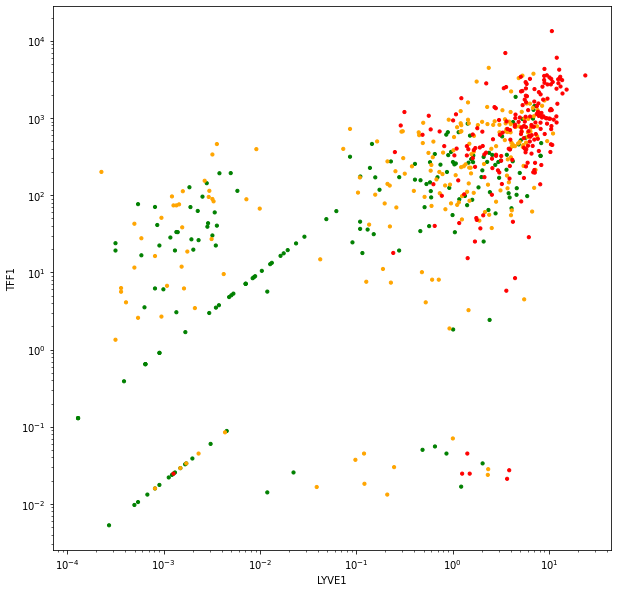

In [92]:
diagnosis_color_map = {1: "green", 2: "orange", 3: "red"}

X.plot.scatter(X.columns[2], X.columns[4], s=10, figsize=(10,10), c=y.map(diagnosis_color_map), logx=True, logy=True);

In questa sezione vengono generati una serie di modelli di learning.

Viene anche generato tramite l'implementazione di Scikit-learn un modello *dummy*, che classifica le istanze in maniera casuale con probabilità uniforme. Questo modello verrà utilizzato in seguito come riferimento per la valutazione degli altri modelli: l'obiettivo *minimo* del progetto è ottenere un modello che sia migliore con confidenza del 99% rispetto al modello dummy di riferimento.

### Modello di riferimento: classificazione casuale

In [93]:
from sklearn.dummy import DummyClassifier

random_classifier = DummyClassifier(strategy="uniform", random_state=21)
random_classifier.fit(X_train, y_train)
random_classifier.score(X_val, y_val)

0.3581081081081081

### Modelli con iperpiani

#### Perceptron

Il perceptron è un modello pensato per classificazione binaria. Può effettuare anche classificazione multiclasse, come richiesto dal problema in esame, in una modalità "one vs rest".





In [94]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron(random_state=21)

perceptron.fit(X_train, y_train)
perceptron.score(X_val, y_val)

0.34459459459459457

In [95]:
perceptron.coef_

array([[ 1.08600000e+03,  2.39777655e+02, -3.55856760e+01,
         5.52346719e+02, -6.42040668e+01,  3.00000000e+01,
         2.00000000e+01],
       [ 4.95000000e+02,  1.02697062e+02, -3.13667092e+02,
        -8.96785498e+02, -1.67214173e+02, -4.00000000e+00,
         8.60000000e+01],
       [-5.16600000e+03, -4.27274835e+02,  4.89886781e+02,
         7.81944924e+02, -3.14635958e+02, -8.20000000e+01,
        -1.37000000e+02]])

In [96]:
perceptron.intercept_

array([  50.,   82., -219.])

Nella grid search vengono ricercati i valori ideali per i seguenti iperparametri: 

*   `scaler`: utilizzare o meno lo StandardScaler per standardizzare le variabili
*   `penalty`: utilizzare o meno di una norma di regolarizzazione, e quale
*   `alpha`: costante di moltiplicazione per la regolarizzazione (se viene utilizzata)
* `n_iter_no_change`: numero di iterazioni senza miglioramento prima di interrompere l'addestramento

In [97]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

skf = StratifiedKFold(3, shuffle=True)

standardized_perceptron = Pipeline([
    ('scaler', StandardScaler()),
    ('perceptron', Perceptron(random_state=21))
])
    
grid = {
    'scaler': [None, StandardScaler()],
    'perceptron__penalty': [None, 'l1', 'l2'],
    'perceptron__alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'perceptron__n_iter_no_change': [5, 7, 10]
}

perceptron_gs = GridSearchCV(standardized_perceptron, grid, cv=skf)
perceptron_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('perceptron',
                                        Perceptron(alpha=0.0001,
                                                   class_weight=None,
                                                   early_stopping=False,
                                                   eta0=1.0, fit_intercept=True,
                                                   max_iter=1000,
                                                   n_iter_no_change=5,
                                                   n_jobs=None, penal...
                                   

Di seguito vengono mostrati i parametri migliori trovati dalla grid search

In [98]:
perceptron_gs.best_params_

{'perceptron__alpha': 0.001,
 'perceptron__n_iter_no_change': 5,
 'perceptron__penalty': 'l1',
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [99]:
perceptron_gs.score(X_val, y_val)

0.46621621621621623

#### Regressione logistica

La regressione logistica può usare due approcci per problemi multiclasse: 
1. One-vs-rest: viene definito un iperpiano per ogni classe e l'etichetta y scelta corrisponde all'iperpiano che massimizza $y = argmax_j(xw_j+b_j$).
2. Multinomial: individua congiuntamente più iperpiani minimizzano la regola di fusione

In [100]:
from sklearn.linear_model import LogisticRegression

logistic_regression = Pipeline([
    ('log_reg', LogisticRegression(multi_class="ovr", solver="saga", max_iter=10000, random_state=21))
])

logistic_regression.fit(X_train, y_train)
logistic_regression.score(X_val, y_val)

0.5608108108108109

Nella grid search vengono ricercati i valori ideali per i seguenti iperparametri: 

*   `scaler`: utilizzare o meno lo StandardScaler per standardizzare le variabili
*   `C`: inversa della regolarizzazione. Valore più bassi applicano una regolarizzazione più marcata
*   `multi_class`: tipologia di approccio alla classificazione multiclasse
*   `penalty`: utilizzo o meno di una norma di regolarizzazione, e quale

In [101]:
logistic_regression = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(solver="saga", max_iter=10000, random_state=21))
])
    
grid = {
    'scaler': [None, StandardScaler()],
    'log_reg__C': [0.1, 0.5, 1, 5, 10],
    'log_reg__multi_class': ['ovr', 'multinomial'], # ovr: binary problem is fit for each label, multinomial: minimisation of multinomial loss fit across the entire probability distribution
    'log_reg__penalty': ['l1', 'l2']
}

logistic_regression_gs = GridSearchCV(logistic_regression, grid, cv=skf)
logistic_regression_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=10000,
              

Di seguito vengono mostrati i parametri migliori trovati dalla grid search

In [102]:
logistic_regression_gs.best_params_

{'log_reg__C': 5,
 'log_reg__multi_class': 'ovr',
 'log_reg__penalty': 'l1',
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [103]:
logistic_regression_gs.score(X_val, y_val)

0.527027027027027

#### SVM

SVM utilizza per costruire l'iperpiano solo i punti più vicini al decision boundary, i cosiddetti *support vectors*. Utilizza funzioni kernel per mappare i dati in spazio con dimensionalità più alta.
Per un problema multiclasse, SVM adotta una strategia one-vs-one: per ogni coppia di classi viene creato un iperpiano di separazione. Si hanno quindi $(N * (N – 1)) / 2$ problemi di classificazione binari; ognuno di questi genera un voto e la classe con più voti totali è quella predetta.

In [104]:
from sklearn.svm import SVC

svm = SVC(random_state=21)

svm.fit(X_train, y_train)
svm.score(X_val, y_val)

0.5202702702702703

Nella grid search vengono ricercati i valori ideali per i seguenti iperparametri: 

*   `scaler`: utilizzare o meno lo StandardScaler per standardizzare le variabili
*   `C`: parametro di regolarizzazione: forza della regolarizzazione inversamente proporzionale a C. La regolarizzazione utilizzata è L2.
*   `kernel`: scelta del kernel da utilizzare nell'algoritmo
*   `gamma`: coefficiente del kernel
*   `degree`: grado del polinomio, solo per kernel polinomiale

In [105]:
svm = Pipeline([
    ('std', StandardScaler()),
    ('svm', SVC(gamma="scale")) # default gamma: 1 / (n_features * X.var())
])

parameters = [
    {'svm__kernel': ['rbf'], # kernel non lineare
    'svm__C': [0.01, 0.1, 1]
    },
    {'svm__kernel': ['poly'], # kernel non lineare
    'svm__C': [0.01, 0.1, 1],
     'svm__degree': [2, 3, 5]
    },
]

svm_gs = GridSearchCV(svm, parameters, cv=skf)
svm_gs.fit(X_train, y_train)
svm_gs.score(X_val, y_val)

0.5067567567567568

Di seguito gli iperparametri migliori trovati tramite la grid search

In [106]:
svm_gs.best_params_

{'svm__C': 1, 'svm__degree': 3, 'svm__kernel': 'poly'}

### K-nearest neighbors

Modello predittivo utilizzato per classificazione e regressione. 
Utilizza un concetto di vicinanza di caratteristiche per predirre il comportamento o la classificazione di un soggetto a seconda di quelli a lui più vicini, vale a dire più simili.

In [107]:
from sklearn.neighbors import KNeighborsClassifier

k_nearest = KNeighborsClassifier()

k_nearest.fit(X_train, y_train)
k_nearest.score(X_val, y_val)

0.4797297297297297

Nella grid search vengono ricercati i valori ideali per i seguenti iperparametri: 

*   `scaler`: utilizzare o meno lo StandardScaler per standardizzare le variabili
*   `n_neighbors`: numero di vicini da considerare
*   `weights`: peso da assegnare ai vicini (uniforme o inverso rispetto alla distanza)
*   `algorithm`: algoritmo utilizzato per trovare i vicini

In [108]:
k_nearest = Pipeline([
    ('scaler', StandardScaler()),
    ('neighbor', KNeighborsClassifier())
])
    
grid = {
    'scaler': [None, StandardScaler()],
    'neighbor__n_neighbors': [1, 3, 5, 10, 20],
    'neighbor__weights': ['uniform', 'distance'],
    'neighbor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

k_nearest_gs = GridSearchCV(k_nearest, grid, cv=skf)
k_nearest_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('neighbor',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weig

In [109]:
k_nearest_gs.best_params_

{'neighbor__algorithm': 'auto',
 'neighbor__n_neighbors': 20,
 'neighbor__weights': 'uniform',
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [110]:
k_nearest_gs.score(X_val, y_val)

0.5135135135135135

### Decision trees

Modello di learning che utilizza il concetto di albero decisionale: a ogni nodo decisionale le istanze vengono "smistate" secondo un criterio costruito dal modello, fino a raggiungere le foglie dell'albero che corrispondono alle etichette da assegnare. 

In [111]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(max_depth=3, criterion="entropy", random_state=21)

decision_tree.fit(X_train, y_train)
decision_tree.score(X_val, y_val)

0.5337837837837838

Un vantaggio di modelli di questo tipo è la possibilità di visualizzare il flusso decisionale "disegnando" l'albero, questo può essere fatto direttamente tramite scikit-learn

[Text(418.5, 713.475, 'LYVE1 <= 1.011\nentropy = 1.581\nsamples = 442\nvalue = [132, 158, 152]\nclass = Benign'),
 Text(209.25, 509.625, 'LYVE1 <= 0.186\nentropy = 1.238\nsamples = 171\nvalue = [89, 73, 9]\nclass = Control'),
 Text(104.625, 305.775, 'REG1B <= 4.158\nentropy = 1.006\nsamples = 108\nvalue = [69, 38, 1]\nclass = Control'),
 Text(52.3125, 101.92499999999995, 'entropy = 1.135\nsamples = 42\nvalue = [19, 22, 1]\nclass = Benign'),
 Text(156.9375, 101.92499999999995, 'entropy = 0.799\nsamples = 66\nvalue = [50, 16, 0]\nclass = Control'),
 Text(313.875, 305.775, 'creatinine <= 0.475\nentropy = 1.375\nsamples = 63\nvalue = [20, 35, 8]\nclass = Benign'),
 Text(261.5625, 101.92499999999995, 'entropy = 1.167\nsamples = 19\nvalue = [1, 12, 6]\nclass = Benign'),
 Text(366.1875, 101.92499999999995, 'entropy = 1.215\nsamples = 44\nvalue = [19, 23, 2]\nclass = Benign'),
 Text(627.75, 509.625, 'LYVE1 <= 5.123\nentropy = 1.433\nsamples = 271\nvalue = [43, 85, 143]\nclass = PDAC'),
 Text(5

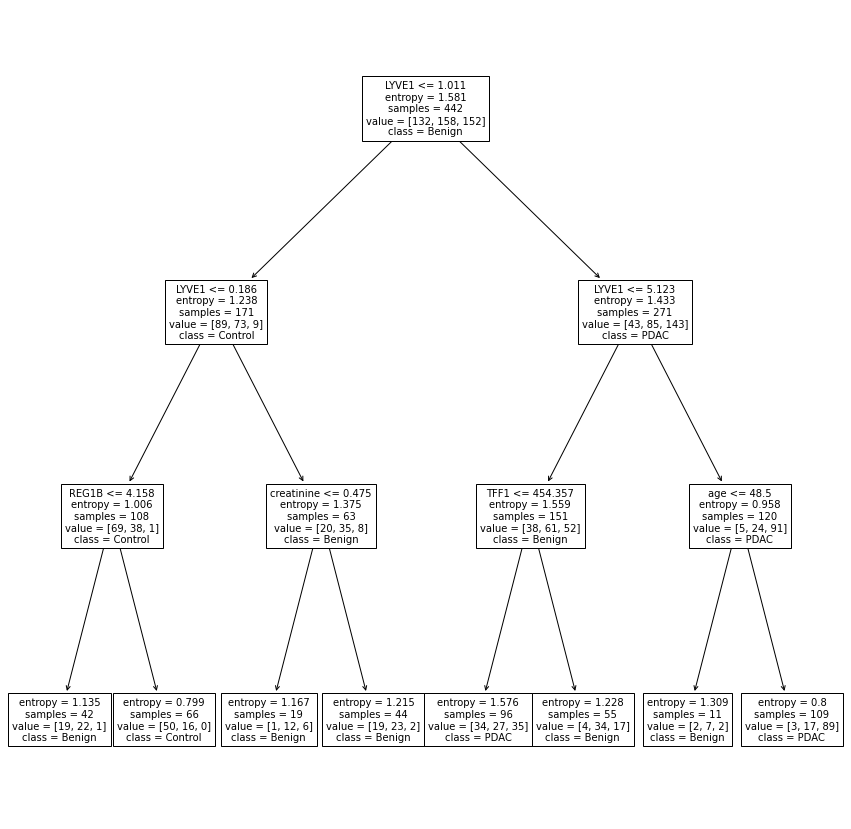

In [112]:
feature_names = ["age", "creatinine",	"LYVE1", "REG1B",	"TFF1", "M", "D"]
class_names = ["Control", "Benign", "PDAC"]

from sklearn import tree
plt.figure(figsize=(15,15))
tree.plot_tree(decision_tree, fontsize=10, class_names=class_names, feature_names=feature_names)


Nella grid search vengono ricercati i valori ideali per i seguenti iperparametri: 

*   `scaler`: utilizzare o meno lo StandardScaler per standardizzare le variabili
*   `criterion`: scelta della funzione che misura la qualità di uno split, ovvero lo smistamento che avviene a ogni nodo
*   `splitter`: strategia per la scelta dello split su cui proseguire
*   `max_features`: numero di features da considerare a ogni split
*   `max_depth`: profondità massima dell'albero decisionale: profondità maggiore porta a una precisione maggiore ma anche a maggiore overfitting

In [113]:
decision_tree = Pipeline([
    ('scaler', StandardScaler()),
    ('dtc', DecisionTreeClassifier(random_state=21))
])
    
grid = {
    'scaler': [None, StandardScaler()],
    'dtc__criterion': ["gini", "entropy"],
    'dtc__splitter': ["best", "random"],
    'dtc__max_features': ["auto", "sqrt", "log2", None],
    'dtc__max_depth': [None, 5, 10, 15]
}

decision_tree_gs = GridSearchCV(decision_tree, grid, cv=skf)
decision_tree_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('dtc',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                       

In [114]:
decision_tree_gs.best_params_

{'dtc__criterion': 'entropy',
 'dtc__max_depth': 5,
 'dtc__max_features': None,
 'dtc__splitter': 'best',
 'scaler': None}

In [115]:
decision_tree_gs.score(X_val, y_val)

0.5675675675675675

In questo caso l'albero non viene visualizzato, in quando non avendo impostato la profondità massima a priori, il modello prediligerà profondità grandi (e non visualizzabili) per ottenere una maggiore precisione.

### XGBoost
Algoritmo che implementa il concetto di gradient boosting.
La libreria *xgboost* fornisce una implementazione di questo algoritmo ed è compatabile con le interfacce di *scikit-learn*.

In [116]:
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='multi:softmax')

xgb.fit(X_train, y_train)
xgb.score(X_val, y_val)

0.5945945945945946

Nella grid search vengono ricercati i valori ideali per i seguenti iperparametri: 

*   `scaler`: utilizzare o meno lo StandardScaler per standardizzare le variabili
*   `alpha`: "forza" della regolarizzazione L1
*   `eta`: Step size
*   `gamma`: Errore minimo per creare una nuova partizione su un nodo foglia
*   `max_depth`: Profondità massima di un albero
*   `subsample`: Ratio del subsampling
*   `colsample_bytree`: Ratio del subsampling sulle colonne

In [117]:
xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(objective='multi:softmax'))
])

params = xgb[1].get_xgb_params()
params["num_class"] = 3

grid = {
 'scaler': [None, StandardScaler()],
 'xgb__alpha': [0.0001, 0.001],
 'xgb__colsample_bytree': [0.6, 1],
 'xgb__eta': [0.002, 0.1, 0.5],
 'xgb__gamma': [0.5, 1, 2, 5],
 'xgb__max_depth': [3, 5, 7],
 'xgb__subsample': [0.6, 0.8, 1.0]
 }

xgb_gs = GridSearchCV(xgb, grid, cv=skf)
xgb_gs.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                        

In [118]:
xgb_gs.best_params_

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'xgb__alpha': 0.0001,
 'xgb__colsample_bytree': 0.6,
 'xgb__eta': 0.002,
 'xgb__gamma': 2,
 'xgb__max_depth': 3,
 'xgb__subsample': 0.6}

In [119]:
xgb_gs.score(X_val, y_val)

0.6283783783783784

## Valutazione dei modelli

In questa sezione vengono valutati i modelli generati nella precedente.

### Confusion matrix

Per ogni modello creato, viene generata una confusion matrix. La confusion matrix mostra per ognuna delle tre classi quante istanze sono state classificate correttamente e quante erroneamente. Viene mostrata con valori percentuali. 

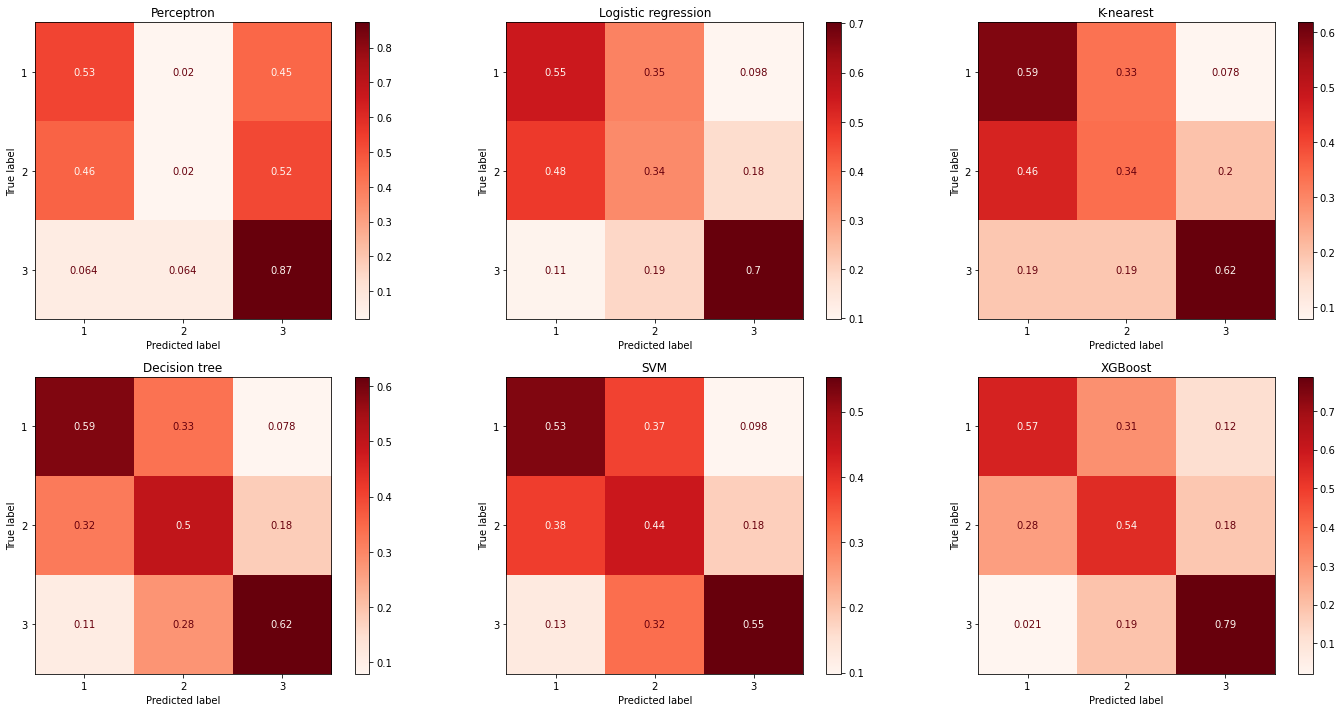

In [120]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

models = [("Perceptron", perceptron_gs), ("Logistic regression", logistic_regression_gs),
          ("K-nearest", k_nearest_gs), ("Decision tree", decision_tree_gs), ("SVM", svm_gs), ("XGBoost", xgb_gs)]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for tup, ax in zip(models, axes.flatten()):
    name = tup[0]
    model = tup[1]
    plot_confusion_matrix(model, X_val, y_val, ax=ax, normalize="true", cmap="Reds")
    ax.title.set_text(name)
plt.tight_layout()  
plt.show()

Intuitivamente, guardando alle matrici di confusione si può dire che in generale la classe più difficile da classificare correttamente sia la 2, ovvero le malattie benigne.

### Precision, recall e F1

Viene ora mostrata una tabella che per ogni modello mostra i tre seguenti indicatori di performance, tutti con valore fra 0 e 1:
1. Precision: percentuale di istanze nel validation set classificate correttamente
2. Recall: percentuale di istanze di una classe che sono classificate come tali
3. F1 measure: Media armonica dei due score precedenti

Si noti che ogni valore è una media dei valori calcolati sulle tre classi.


In [121]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_indicators(model):
  y_pred = model.predict(X_val)
  precision = precision_score(y_val, y_pred, average="macro")
  recall = recall_score(y_val, y_pred, average="macro")
  f1 = f1_score(y_val, y_pred, average="macro")

  return precision, recall, f1

In [122]:
pd.DataFrame([compute_indicators(perceptron_gs), compute_indicators(logistic_regression_gs), compute_indicators(k_nearest_gs),
              compute_indicators(decision_tree_gs), compute_indicators(svm_gs), compute_indicators(xgb_gs)],
              index=["Perceptron", "Logistic regression", "K-nearest", "Decision trees", "SVM", "XGBoost"], columns=["Precison", "Recall", "F1 measure"])

,Precison,Recall,F1 measure
Perceptron,0.388330,0.473917,0.384712
Logistic regression,0.526573,0.530382,0.527449
K-nearest,0.517879,0.515086,0.513670
Decision trees,0.577752,0.568419,0.572037
SVM,0.520696,0.507534,0.512356
XGBoost,0.629953,0.631954,0.629138


### Intervallo di fiducia


Per i modelli viene ora calcolato l'intervallo di fiducia. Si ricerca l'intervallo entro cui si trova la precisione del modello con una data certezza, in questo caso il 95%

In [123]:
from scipy.stats import norm

def conf_interval(a, N, Z=1.96):
    c = (2 * N * a + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
    return c - d, c + d

def compute_conf_interval(model, X=X_val, y=y_val, level=0.95):
   a = model.score(X, y)
   N = len(X)
   Z = norm.ppf((1 + level) / 2)
   return conf_interval(a, N, Z)

Di seguito viene mostrata una tabella con i limiti inferiori e superiori degli intervalli di fiducia al 95% dei modelli creati.

In [124]:
pd.DataFrame([compute_conf_interval(perceptron_gs), compute_conf_interval(logistic_regression_gs), compute_conf_interval(k_nearest_gs),
              compute_conf_interval(decision_tree_gs), compute_conf_interval(svm_gs), compute_conf_interval(xgb_gs)],
              index=["Perceptron", "Logistic regression", "K-nearest", "Decision trees", "SVM", "XGBoost"], columns=["Limite inferiore", "Limite superiore"])

,Limite inferiore,Limite superiore
Perceptron,0.387720,0.546422
Logistic regression,0.446928,0.605758
K-nearest,0.433671,0.592672
Decision trees,0.487041,0.644676
SVM,0.427064,0.586107
XGBoost,0.548200,0.702062


Per ottenere intervalli più piccoli, occorre avere un maggior numero di valutazioni, ovvero un dataset più ampio.

### Confronto tra i modelli

In [125]:
def diff_interval(a1, a2, N1, N2, Z):
    variance = a1*(1-a1)/N1 + a2*(1-a2)/N2
    abs_diff = abs(a1-a2)
    return abs_diff - Z * np.sqrt(variance), abs_diff + Z * np.sqrt(variance)

def model_diff_interval(m1, m2, X=X_val, y=y_val, level=0.95):
   a1 = m1.score(X, y)
   a2 = m2.score(X, y)
   N = len(X)
   Z = norm.ppf((1 + level) / 2)
   return diff_interval(a1, a2, N, N, Z)

Vengono confrontati tra loro i tre modelli con F1 score più alto.

In [126]:
model_diff_interval(k_nearest_gs, svm_gs)

(-0.10713782836937366, 0.12065134188288704)

In [127]:
model_diff_interval(k_nearest_gs, xgb_gs)

(0.002858687776762847, 0.22687104195296698)

In [128]:
model_diff_interval(svm_gs, xgb_gs)

(0.009599576264390106, 0.23364366697885308)

Nonostante i tre modelli presi in esame abbiano F1 score diversi, non si può dire con certezza al 95% che uno sia migliore degli altri, in quanto nessun intervallo include gli zeri.

## Conclusioni

### Confronto del modello migliore individuato con modello casuale

Per valutare che il modello ottenuto sia migliore di quello casuale di riferimento, li si confronta con certezza al 99%:

In [129]:
model_diff_interval(random_classifier, xgb_gs, level=0.99)

(0.12613922786469708, 0.41440131267584346)

Il modello XGBoost ottenuto è dunque migliore di quello dummy.

### Spunti per migliorare il modello

Confronto score del modello migliore train set vs validation set

Riduzione di numero variabili per ridurre overfitting. Per decidere quali variabili rimuovere bisogna capire quali il modello considera meno importanti.

Analizzando il modello, si intuisce che possa soffrire di overfitting, essendo troppo "aderente" alle variabili utilizzate nella fase di training. Questa intuizione può essere confermata confrontando gli score ottenuti dal modello sui dati di training rispetto ai dati di validation:

In [130]:
print("Score su dati di training:", f1_score(y_train, xgb_gs.predict(X_train), average="macro"))
print("Score su dati di validation:", f1_score(y_val, xgb_gs.predict(X_val), average="macro"))

Score su dati di training: 0.7850621771037863
Score su dati di validation: 0.6291376093233678


Il modello ottiene uno score significativamente più basso sul validation set. Per risolvere questo overfitting, la soluzione ideale sarebbe l'utilizzo di un dataset più ampio, tuttavia non è disponibile sul web un dataset simile a quello utilizzato che fornisca più istanze. Un altro tentativo di ridurre l'overfitting può essere fatto riducendo il numero di feature; per fare ciò occorre prima capire quali sono le feature meno rilevanti secondo il modello

In [131]:
features = pd.DataFrame()
features['name'] = X.columns
features['relevance'] = xgb_gs.best_estimator_["xgb"].feature_importances_
features.sort_values(by='relevance',ascending=False,inplace=True)

features

,name,relevance
4,TFF1,0.180560
2,LYVE1,0.171198
0,age,0.165632
3,REG1B,0.149919
1,creatinine,0.124543
5,sex_F,0.118773
6,sex_M,0.089375


In [132]:
X_train_new = X_train.drop(columns=["sex_M", "sex_F", "creatinine"])
X_val_new = X_val.drop(columns=["sex_M", "sex_F", "creatinine"])

In [133]:
xgb_gs_new = GridSearchCV(xgb, grid, cv=skf)
xgb_gs_new.fit(X_train_new, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                        

In [134]:
pd.DataFrame([[f1_score(y_train, xgb_gs.predict(X_train), average="macro"), f1_score(y_val, xgb_gs.predict(X_val), average="macro")],
              [f1_score(y_train, xgb_gs_new.predict(X_train_new), average="macro"), f1_score(y_val, xgb_gs_new.predict(X_val_new), average="macro")]],
              index=["All features", "4 most relevant features"], columns=["F1 su training set", "F1 su validation set"])

,F1 su training set,F1 su validation set
All features,0.785062,0.629138
4 most relevant features,0.777741,0.609648


Conclusioni: come si evince dalla tabella, questo tentativo ha successo nel diminuire l'overfitting, in quanto c'è meno differenza negli score fra training e validation. Tuttavia, anche a fronte di minor overfitting, il nuovo dataset produce uno score nel complesso più basso.